<a href="https://colab.research.google.com/github/Sagacious007/BIG-data-assessment/blob/main/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import json
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
import nltk
import pyLDAvis
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
from tqdm import tqdm
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stopwords = stopwords.words('english')
from transformers import pipeline
from keras.layers import Dense,Embedding,LSTM,Dropout
import tensorflow as tf
from keras.models import Sequential
from sklearn.feature_extraction.text import TfidfVectorizer
# print(stopwords)

c:\Users\Risto Trajanov\anaconda3\envs\myenv\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
[nltk_data] Downloading package stopwords to C:\Users\Risto
[nltk_data]     Trajanov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\Risto Trajanov\anaconda3\envs\myenv\lib\site-packages\keras\utils\image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
c:\Users\Risto Trajanov\anaconda3\envs\myenv\lib\site-packages\keras\utils\image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
c:\Users\Risto Trajanov\anaconda3\envs\myenv\lib\site-packages\keras\utils\imag

In [ ]:
# Sentiment model
model_sentiment = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [ ]:
# Website forum address
website = 'https://rheumatoidarthritis.net/forums'
# Domain
website_origin = 'https://rheumatoidarthritis.net'

# Crawler

In [ ]:
# Get all the links to the stories from the forum
links = []
for i in range(100):
    # Iterate 100 pages of the forum
    website_pagination = website + f'?page={i}'
    req = requests.get(website_pagination)
    parsed_html = BeautifulSoup(req.text)
    # Get the threads and find all the articles in it, article is the post from the story
    for post in parsed_html.find('div', attrs={'class':'forums-index__threads'}).find_all('article'):
        # From the post extract the link to the story and make it usable for our next step
        links.append(website_origin + post.find('a')['href'])
        print(post.find('a')['href'])

/forums/nodules
/forums/ask-me-anything-live
/forums/help-im-alone-confused-and-in-pain
/forums/just-diagnosed-with-seropositive-ra-61-years-old
/forums/pain-in-lower-right-quadrant-of-back
/forums/effects-of-covid-vaccines-on-our-ra
/forums/diagnosed-today-34yr-old
/forums/ra-disappearing
/forums/seronegative-odd-symptoms
/forums/work-issues
/forums/headche-problem-in-ra
/forums/nodules
/forums/ask-me-anything-live
/forums/help-im-alone-confused-and-in-pain
/forums/just-diagnosed-with-seropositive-ra-61-years-old
/forums/pain-in-lower-right-quadrant-of-back
/forums/effects-of-covid-vaccines-on-our-ra
/forums/diagnosed-today-34yr-old
/forums/ra-disappearing
/forums/seronegative-odd-symptoms
/forums/work-issues
/forums/headche-problem-in-ra
/forums/just-diagnosed-2
/forums/energy-humira
/forums/rheum
/forums/diagnosed-later-in-age
/forums/getting-on-humira
/forums/medication-reset
/forums/holistic-doctor
/forums/pain-and-ra
/forums/humira-concerns
/forums/nodules-face-neck-scalp
/forums

In [ ]:
print(len(set(links)))

990


In [ ]:
# Extract title, content and comments from a story
data = {}
for link in tqdm(links):
    try:
        req = requests.get(link)
        parsed_html = BeautifulSoup(req.text)
        # Get the title - h1 tag
        title = parsed_html.find('div', attrs={'class':'forum-thread__content'}).find('h1').text
        content = ''
        # Get the content from the multiple p tags from the body of the story
        for p in parsed_html.find('div', attrs={'class':'forum-thread__body'}).find_all('p'):
            content += p.text
        comments = []
        # Get the content from the comments same as the main content
        for div in parsed_html.find_all('div', attrs={'class':'thread-reply__body'}):
            content_comment = ''
            for p in div.find_all('p'):
                content_comment += p.text
            comments.append(content_comment)
        meta_data = {'content':content, 'comments':comments, 'title':title}
        data[link] = meta_data
    except Exception as e:
        print(e)

100%|██████████| 1002/1002 [17:09<00:00,  1.03s/it]


In [ ]:
print(len(data.keys()))

990


In [ ]:
# Save the data as json
with open('data.json', 'w') as f:
    json.dump(data, f)

# Preprocess

In [ ]:
# Get the most frequent words so we can eliminate really rare words from our corpus
def most_frequent_words(posts:list):
    count_vectorizer =  CountVectorizer(max_features=1000)
    feature_vector = count_vectorizer.fit(posts)
    features = feature_vector.get_feature_names()
    train_ds_features = count_vectorizer.transform(posts)
    features_counts =  np.sum(train_ds_features.toarray(),axis=0)
    features_counts = pd.DataFrame(dict(features = features, counts = features_counts))
    features_counts.sort_values('counts', ascending=False)[0:15]
    return features_counts['features'].values.tolist()

In [ ]:
# Text cleaning function - stopwords, numbers, small words, links, and adhoc words
def remove_stopwords_and_numbers(post:str):
    tokens = word_tokenize(post)
    new_post = [word for word in tokens if word not in stopwords and not word.isnumeric() and word not in punctuation and len(word)>3 and word.lower() != 'net' and word.lower() != 'https' and not word.startswith('http') and not word.endswith('.net')]
    return ' '.join(new_post)

In [ ]:
# function to remove not freq
def remove_not_frequent(post:str, most_frequent:list):
    tokens = word_tokenize(post)
    new_post = [word for word in tokens if word in most_frequent]
    return ' '.join(new_post)

In [ ]:
# Get all texts, gett all possible string into one list
all_posts = []
for link, meta in data.items():
    all_posts.append(meta['content'])
    for comment in meta['comments']:
        all_posts.append(comment)

In [ ]:
# Get most frequent words into one array
most_frequent = most_frequent_words(all_posts)

C:\Users\Risto\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Clean the data with - preprocessing
data_clean = {}
for link, meta in data.items():
    content = meta['content']
    # Removing the stopwords
    new_content = remove_stopwords_and_numbers(content)
    
    new_comments = []
    for comment in meta['comments']:
        # Get all the comments in one string and clean them of stopwords and numbers
        new_comments.append(remove_stopwords_and_numbers(comment))
    data_clean[link] = {'content':new_content, 'comments':new_comments, 'title': remove_stopwords_and_numbers(meta['title'])}

In [ ]:
# Save into a json object clean data
with open('data_clean.json', 'w') as f:
    json.dump(data_clean, f)

# Topic Modeling

In [ ]:
# Open clean data from json file
with open('data_clean.json', 'r') as f:
  data_clean = json.load(f)

In [ ]:
# Take all texts, content and comments into one list
all_text = []
for link, meta in data_clean.items():
    all_text.append(meta['content'])
    for comment in meta['comments']:
        all_text.append(comment)

In [ ]:
# Make all texts lowercase
all_text_lowercase = []
for text in all_text:
    new_text = word_tokenize(text)
    new_text = [word.lower() for word in new_text if word.lower() != 'net']
    all_text_lowercase.append(' '.join(new_text))

## Word Cloud

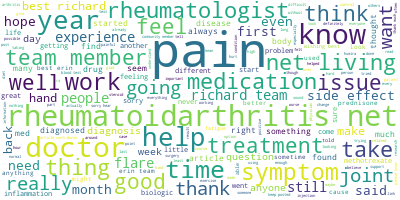

In [ ]:
# Join the different processed titles together.
long_string = ','.join(all_text_lowercase)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [ ]:
# Sentence to word function
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [ ]:
data_words = list(sent_to_words(all_text_lowercase))

In [ ]:
print(data_words[:1][0][:30])

['does', 'anyone', 'know', 'nodules', 'show', 'skin']


In [ ]:
data_words

[['does', 'anyone', 'know', 'nodules', 'show', 'skin'],
 ['responded',
  'another',
  'thread',
  'thought',
  'would',
  'share',
  'article',
  'well',
  'net',
  'what',
  'is',
  'ra',
  'ra',
  'nodules',
  'experiencing',
  'lumps',
  'near',
  'skin',
  'surface',
  'hope',
  'helps',
  'wishing',
  'best',
  'lori',
  'team',
  'member'],
 ['hello',
  'lori',
  'thought',
  'heard',
  'nodules',
  'show',
  'places',
  'skin',
  'obvious',
  'finger',
  'joint',
  'appox',
  'year',
  'another',
  'early',
  'diagnoses',
  'finger',
  'joint',
  'came',
  'disappeared',
  'reason',
  'asking',
  'places',
  'nodule',
  'growing',
  'lung',
  'followed',
  'possible',
  'cancer',
  'guess',
  'next',
  'rheumatologist',
  'also',
  'look',
  'scans',
  'done',
  'scan',
  'base',
  'skull',
  'hips',
  'what',
  'might',
  'thought',
  'nodules',
  'developing',
  'lungs',
  'heart',
  'thanks',
  'response',
  'john'],
 ['nodules',
  'sometimes',
  'occur',
  'lung',
  'article

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]


In [ ]:
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.007*"symptoms" + 0.006*"also" + 0.006*"side" + 0.006*"would" + '
  '0.006*"hope" + 0.005*"best" + 0.005*"pain" + 0.005*"doctor" + 0.005*"years" '
  '+ 0.005*"meds"'),
 (1,
  '0.013*"team" + 0.011*"best" + 0.010*"net" + 0.010*"know" + 0.008*"also" + '
  '0.008*"article" + 0.007*"living" + 0.006*"diagnosis" + 0.006*"experience" + '
  '0.006*"community"'),
 (2,
  '0.008*"would" + 0.006*"thank" + 0.006*"know" + 0.005*"doctor" + '
  '0.005*"also" + 0.005*"could" + 0.005*"years" + 0.005*"hope" + 0.004*"like" '
  '+ 0.004*"arthritis"'),
 (3,
  '0.010*"pain" + 0.008*"doctor" + 0.007*"know" + 0.007*"team" + 0.006*"much" '
  '+ 0.006*"feel" + 0.006*"best" + 0.005*"years" + 0.005*"also" + '
  '0.005*"side"'),
 (4,
  '0.018*"pain" + 0.009*"team" + 0.008*"net" + 0.007*"doctor" + 0.007*"like" + '
  '0.007*"best" + 0.007*"know" + 0.006*"work" + 0.006*"living" + '
  '0.005*"article"'),
 (5,
  '0.011*"best" + 0.011*"hope" + 0.010*"team" + 0.010*"net" + 0.009*"know" + '
  '0.007*"like" + 0.007

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = './ldavis_prepared_'+str(num_topics)
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

c:\Users\Risto\.conda\envs\newEnv\lib\site-packages\pyLDAvis\_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.019765 -0.019717       1        1  17.980069
4      0.013007 -0.005616       2        1  15.102753
1      0.038682  0.024249       3        1  13.810922
5      0.031581  0.016362       4        1  12.344159
7     -0.001942 -0.017990       5        1   8.617774
8      0.003312 -0.000560       6        1   8.003731
9     -0.007155 -0.013024       7        1   7.586841
0     -0.003976 -0.011701       8        1   7.570074
3     -0.005821 -0.014310       9        1   5.927730
2     -0.047922  0.042307      10        1   3.055948, topic_info=               Term         Freq        Total Category  logprob  loglift
28            would   871.000000   871.000000  Default  30.0000  30.0000
280            pain  1826.000000  1826.000000  Default  29.0000  29.0000
148           thank   633.000000   633.000000  Default  28.0000  28.0000
11             hope   815.000000   815.000000  Default  27.0000  27.0000
22             team  1294.000000  1294.000000  Default  26.0000  26.0000
..              ...          ...          ...      ...      ...      ...
144            good    18.847783   684.334572  Topic10  -5.6935  -0.1040
268        symptoms    18.423988   713.959202  Topic10  -5.7162  -0.1691
22             team    19.496399  1294.644261  Topic10  -5.6597  -0.7077
280            pain    19.983359  1826.787858  Topic10  -5.6350  -1.0273
61   rheumatologist    16.171878   853.726187  Topic10  -5.8466  -0.4783

[872 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
96         1  0.177888     able
96         2  0.117031     able
96         3  0.168525     able
96         4  0.131075     able
96         5  0.053834     able
...      ...       ...      ...
220        9  0.065163    years
220       10  0.028716    years
10114      7  0.582545    yucky
9695       6  0.311527  zohydro
9695       9  0.623053  zohydro

[2532 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 2, 6, 8, 9, 10, 1, 4, 3])

# Sentiment analysis

In [ ]:
sent = []
s_val = []
for s in all_text:
    if len(s) < 2000:
        result = model_sentiment(s)[0]
        if result['label'] == "NEGATIVE":
            sent.append(-1)
            s_val.append(-result['score'])
        else:
            sent.append(1)
            s_val.append(result['score'])
    else:
        sent.append(0)
        s_val.append(0)


In [ ]:
df = pd.DataFrame({'text': all_text, 'sentiment_value':s_val, 'sentiment':sent})

In [ ]:
df

,text,sentiment_value,sentiment
0,Does anyone know nodules show skin,-0.980372,-1
1,responded another thread thought would share a...,-0.977514,-1
2,Hello Lori thought heard nodules show places s...,-0.987397,-1
3,nodules sometimes occur lung article Mayo clin...,0.741058,1
4,scheduled Scan neck thigh Pulmonologist visit ...,-0.958718,-1
...,...,...,...
4358,Welcome TC3120 First totally normal feel overw...,0.895511,1
4359,Health Gainer purely herbal manufacturing guar...,0.610022,1
4360,work year poly diagnosis seropositive insuranc...,-0.823155,-1
4361,Lavande certain amount fear concern certainly ...,-0.918514,-1


In [ ]:
df.to_csv('text_with_sentiment.csv')

In [ ]:
df = pd.read_csv('./text_with_sentiment.csv')

In [ ]:
# Map the integer sentiment to string sentiment for better vizualization
dict_map = {-1: "Negative" , 1: "Positive", 0: 'Neutral'}
df['Sentiment_'] = df['sentiment'].map(dict_map).astype(str)

c:\Users\Risto Trajanov\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# Group by the sentiment so that we can count it and plot it
dfg = df.groupby(['Sentiment_'])['text'].count()

In [ ]:
dfg

Sentiment_
Negative    2886
Neutral       16
Positive    1399
Name: text, dtype: int64

<AxesSubplot:title={'center':'Sentiment'}, xlabel='Count', ylabel='Sentiment'>

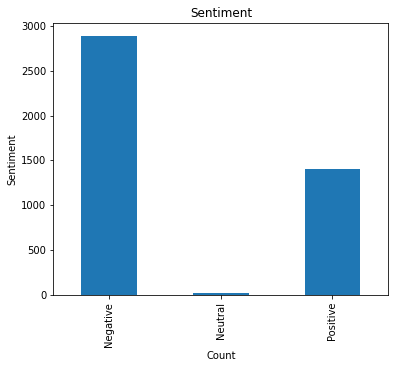

In [ ]:
# Plot
dfg.plot(kind='bar', title='Sentiment', ylabel='Sentiment',
         xlabel='Count', figsize=(6, 5))

## Deep Learning sentiment analysis

In [ ]:
df = df.dropna()

In [ ]:
# Get all the texts into one list
corpus = df['text']
# Label is the sentiment
y = df['sentiment']

In [ ]:
# Do a TF IDF on the corpus so we can feed that to the neural network
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

In [ ]:
X_tf = X.toarray()  
X_tf = X_tf[:, :, None]  

In [ ]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tf, y, test_size=0.2, random_state=0)

In [ ]:
# Build a Neural network with three layers with 500, 100 and 10 neurons and in the end one output layer
model = Sequential()

model.add(Dense(units = 500,
                activation = "relu"))

model.add(Dense(units = 100,
                activation = "relu"))

                
model.add(Dense(units = 10,
                activation = "relu"))

model.add(Dense(1,
                activation = "sigmoid"))

model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.01),
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

c:\Users\Risto Trajanov\anaconda3\envs\myenv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# After training a while I stopped the model because the accuracy is not that 
# good and we conclude that DNN is not suitable for this problem
model.fit(X_train, y_train, batch_size=128, epochs=10)

Epoch 1/10
27/27 [==============================] - 156s 6s/step - loss: -2.8587 - accuracy: 0.0041
Epoch 2/10
27/27 [==============================] - 162s 6s/step - loss: -5.3808 - accuracy: 0.0041
Epoch 3/10
27/27 [==============================] - 156s 6s/step - loss: -5.3808 - accuracy: 0.0041
Epoch 4/10
27/27 [==============================] - 129s 5s/step - loss: -5.3808 - accuracy: 0.0041
Epoch 5/10
26/27 [===========================>..] - ETA: 5s - loss: -5.3348 - accuracy: 0.0039 

KeyboardInterrupt: 